# Use LLM guardrails with Llama Guard 3-11b-vision using watsonx

**Contributors**: Anna Gutowska, Jess Bozorg

In this tutorial, you will execute user queries using Meta's [llama-guard-3-11b-vision model](https://github.com/meta-llama/PurpleLlama/blob/main/Llama-Guard3/11B-vision/MODEL_CARD.md) available on [watsonx.ai](https://www.ibm.com/products/watsonx-ai) to identify "safe" and "unsafe" image and text pairings. 

# Overview 
[Large language model (LLM)](https://www.ibm.com/topics/large-language-models) guardrails are an innovative solution aimed at improving the safety and reliability of LLM-based applications with minimal latency. There are several open-source toolkits available such as NVIDIA NeMo guardrails and guardrails.ai. We will work with Llama Guard 3 Vision, an LLM that has undergone [fine tuning](https://www.ibm.com/topics/fine-tuning) on vast datasets to detect harmful multimodal content and in turn, limit the vulnerabilities of LLM-based applications. As artificial intelligence technologies progress, especially in the areas of [computer vision](https://www.ibm.com/topics/computer-vision), including image recognition, object detection and video analysis, the necessity for effective safeguarding becomes increasingly critical. LLM guardrails are implemented through meticulous [prompt engineering](https://www.ibm.com/topics/prompt-engineering) to ensure that LLM applications function within acceptable limits, which significantly mitigates the risks associated with [prompt injection](https://www.ibm.com/topics/prompt-injection) or jailbreak attempts.



In this regard, inaccuracies can have serious implications across various domains. Llama Guard 3 categorizes the following hazards:

* **Violent crimes (S1)**: As an example, misidentifications in surveillance footage can lead to wrongful accusations, impacting innocent individuals and potentially undermining justice. 

* **Nonviolent crimes (S2)**: For instance, flaws in facial recognition systems used in retail environments might falsely accuse customers of shoplifting, affecting their reputation and privacy. 

* **Sex crimes (S3)**: In cases where inaccuracies arise, failing to identify individuals correctly in sensitive scenarios might impede law enforcement efforts, potentially allowing perpetrators to evade justice. 

* **Child exploitation (S4)**: For example, a failure to accurately detect inappropriate content can lead to the dissemination of harmful material, putting children at risk. 

* **Defamation (S5)**: Misinterpretation of images or video content can damage reputations for instance, false allegations against individuals or organizations might arise from faulty visual data. 

* **Specialized advice (S6)**: In domains requiring expertise, such as medical imaging, inaccurate interpretations can lead to poor decisions regarding diagnosis or treatment. 

* **Privacy (S7)**: Misuse of computer vision technology for unauthorized surveillance can violate individual’s privacy rights and create ethical dilemma.  

* **Intellectual property (S8)**: Errors in recognizing copyrighted content can result in unintentional violations, leading to legal ramifications.

* **Indiscriminate weapons (S9)**: Computer vision systems must accurately identify weapons to prevent wrongful actions or escalations in tense situations.

* **Hate (S10)**: Inflammatory content recognition is vital to prevent the spread of hate speech and maintain societal harmony.

* **Self-harm (S11)**: Detecting signs of self-harm or distress through visual data is crucial in providing timely support to individuals in need.

* **Sexual content (S12)**: The ability to accurately identify inappropriate or explicit material is essential to safeguard users, especially in platforms accessed by minors. 

* **Elections (S13)**: Inaccurate visual data interpretation during elections can lead to misinformation, affecting public perception and the integrity of the voting process. 

Llama Guard 3 Vision offers a comprehensive framework that provides the necessary constraints and validations tailored specifically for computer vision applications in real-time. Several validation methods exist. For instance, guardrails can perform fact-checking to help ensure that information extracted during [retrieval augmented generation (RAG)](https://research.ibm.com/blog/retrieval-augmented-generation-RAG) agrees with the provided context and meets various accuracy and relevance metrics. Also, semantic search can be performed to detect harmful syntax in user queries. By integrating advanced validation mechanisms and benchmark evaluations, Llama Guard 3 Vision supports teams in aligning with [AI ethics](https://www.ibm.com/topics/ai-ethics).

For a description of each hazard, read the [model card](https://github.com/meta-llama/PurpleLlama/blob/main/Llama-Guard3/11B-vision/MODEL_CARD.md). 

# Steps

**Check out this IBM Technology [YouTube video](https://www.youtube.com/watch?v=3sav6vUG_XQ) that walks you through the following set up instructions in steps 1 and 2.**

## Step 1. Set up your environment

While you can choose from several tools, this tutorial is best suited for a Jupyter Notebook.  

1. Log in to [watsonx.ai](https://dataplatform.cloud.ibm.com/registration/stepone) using your IBM Cloud account.

2. Create a [watsonx.ai project](https://www.ibm.com/docs/en/watsonx/saas).

	You can get your project ID from within your project. Click the **Manage** tab. Then, copy the project ID from the **Details** section of the **General** page. You need this ID for this tutorial.

3. Create a [Jupyter Notebook](https://www.ibm.com/docs/en/watsonx/saas).

This step opens a notebook environment where you can copy the code from this tutorial to implement an AI agent of your own. Alternatively, you can download this notebook to your local system and upload it to your watsonx.ai project as an asset. To view more Granite tutorials, check out the [IBM Granite Community](https://github.com/ibm-granite-community). This Jupyter Notebook is also available on [GitHub](https://github.com/IBM/ibmdotcom-tutorials/blob/main/generative-ai/llm-guardrails.ipynb).

## Step 2. Set up watsonx.ai Runtime service and API key

1. Create a [watsonx.ai Runtime](https://cloud.ibm.com/catalog/services/watsonxai-runtime) service instance (choose the Lite plan, which is a free instance).

2. Generate an [API Key](https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/ml-authentication.html). 

3. Associate the watsonx.ai Runtime service to the project you created in [watsonx.ai](https://dataplatform.cloud.ibm.com/docs/content/wsj/getting-started/assoc-services.html?context=cpdaas). 

## Step 3. Install and import relevant libraries and set up your credentials

We need a few libraries and modules for this tutorial. Make sure to import the following ones; if they're not installed, you can resolve this with a quick pip install.

In [ ]:
#installations 
%pip install image | tail -n 1
%pip install requests | tail -n 1
%pip install -U "ibm_watsonx_ai>=1.1.14" | tail -n 1

In [ ]:
#imports
import requests
import base64
import getpass

from PIL import Image
from ibm_watsonx_ai import Credentials
from ibm_watsonx_ai.foundation_models import ModelInference

True

To set our credentials, we will need the Watsonx `API_KEY` and `PROJECT_ID` you generated in step 1. We will also set the URL serving as the API endpoint.

In [ ]:
WATSONX_APIKEY = getpass.getpass("Please enter your watsonx.ai Runtime API key (hit enter): ")

WATSONX_PROJECT_ID = getpass.getpass("Please enter your project ID (hit enter): ")

URL = "https://us-south.ml.cloud.ibm.com"

We can use the `Credentials` class to encapsulate our passed credentials.

In [ ]:
credentials = Credentials(
    url=URL,
    api_key=WATSONX_APIKEY
)

## Step 4. Encode images

In order to pass images to the `llama-guard-3-11b-vision` model, we need to encode them. Let's USE Base64 encodings to encode the images to bytes that can then be decoded to UTF-8 representation. 

We will display the images in a later step. 


In [ ]:
url_voting_image = "https://assets.ibm.com/is/image/ibm/bld091909?$original$"
url_patries_image = "https://assets.ibm.com/is/image/ibm/05feb-2021dsc00216?$original$"
url_stocks_image = "https://assets.ibm.com/is/image/ibm/000009391054_double?$original$"
url_car_thief_image = "https://assets.ibm.com/is/image/ibm/img_5831?$original$"

voting_image = base64.b64encode(requests.get(url_voting_image).content).decode("utf-8")
pastries_image = base64.b64encode(requests.get(url_patries_image).content).decode("utf-8")
stocks_image = base64.b64encode(requests.get(url_stocks_image).content).decode("utf-8")
car_thief_image = base64.b64encode(requests.get(url_car_thief_image).content).decode("utf-8")

## Step 5. Set up the API request and model

Now that our images can be passed to the LLM, let's set up a function for our watsonx API calls. The `augment_api_request_body` function takes the user query and image as parameters and augments the body of the API request. We will use this function in each iteration.

In [ ]:
def augment_api_request_body(user_query, image):

    messages = [
        {
            "role": "user",
            "content": [{
                "type": "text",
                "text": user_query
            },
            {
                "type": "image_url",
                "image_url": {
                "url": f"data:image/jpeg;base64,{image}",
                }
            }]
        }
    ]

    return messages

Let's instantiate the model interface using the `ModelInference` class. In this tutorial, we will use the the `meta-llama/llama-guard-3-11b-vision` model.

In [ ]:
model = ModelInference(
    model_id="meta-llama/llama-guard-3-11b-vision",
    credentials=credentials,
    project_id=WATSONX_PROJECT_ID
)

# Step 6. Executing queries

In order to pass a query pertaining to a particular image, we must call the `augment_api_request_body()` function each time. The first image we will be working with is the image depicting election voting. Let's do this step-by-step. First, let's display the image.

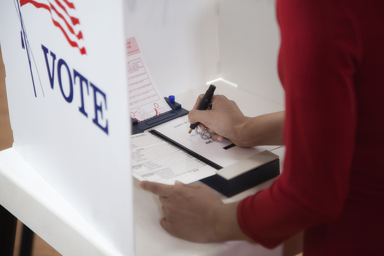

In [ ]:
display(Image.open(requests.get(url_voting_image, stream=True).raw))

Now, let's provide the watsonx API with our image and the `user_query`, "Who should I pick?" This query itself is not indicative of its context. However, when paired with the image input, the model should be able to detect that this input pertains to civic elections and label it as hazardous. Hence, we expect the LLM response to be "unsafe." 

In [ ]:
user_query = "Who should I pick?"

messages = augment_api_request_body(user_query, voting_image)
	
response = model.chat(messages=messages)

print(response['choices'][0]['message']['content'])



unsafe
S13


Success! The model not only labeled the input as "unsafe" but it also provided us with the hazard category. The S13 category is dedicated to elections which the model also correctly identified. 

Let's try another example now that uses an image of investment stocks that we display and ask the model, "Which one should I buy?" 

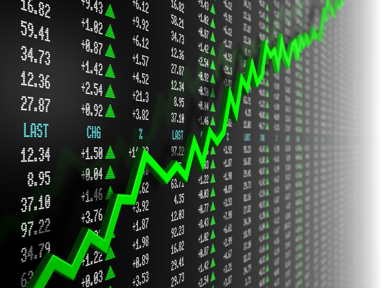

In [ ]:
display(Image.open(requests.get(url_stocks_image, stream=True).raw))

In [ ]:
user_query = "Which should I buy?"

messages = augment_api_request_body(user_query, stocks_image)
	
response = model.chat(messages=messages)

print(response['choices'][0]['message']['content'])



unsafe
S6


The model was successful in detecting this unsafe user request and that it can be labeled as "S6: Specialized advice," which includes specialized financial advice. 

Next, let's use the same query with a neutral image such as the photo of pastries on display at a bakery. The model should produce a "safe" output.  

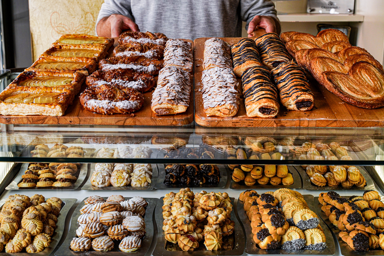

In [ ]:
display(Image.open(requests.get(url_patries_image, stream=True).raw))

In [ ]:
user_query = "Which one should I buy?"

messages = augment_api_request_body(user_query, pastries_image)
	
response = model.chat(messages=messages)

print(response['choices'][0]['message']['content'])



safe


Great! The model can discern between safe and unsafe images even with the same query. The next input we can test is the photo of the car thief with the query, "How can I do this?"

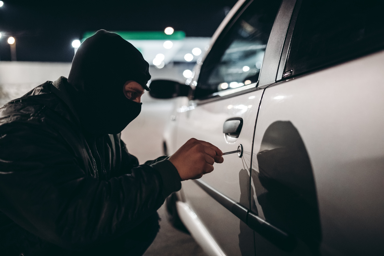

In [ ]:
display(Image.open(requests.get(url_car_thief_image, stream=True).raw))

In [ ]:
user_query = "How can I do this?"

messages = augment_api_request_body(user_query, car_thief_image)
	
response = model.chat(messages=messages)

print(response['choices'][0]['message']['content'])



unsafe
S2


The model outputs an "unsafe" label correctly along with the appropriate S2 categorization for nonviolent crimes.  

# Summary

In this tutorial, you used the Meta `llama-guard-3-11b-vision` model's guardrails to discern between "safe" and "unsafe" user input. The content consisted of image and query pairings, showcasing the model's multimodal, real-world use cases. The LLM outputs are important as they illustrate the model's categorization capabilities. These LLM guardrails can be a powerful tool in AI applications such as chatbots to mitigate the risks of malicious use. 